# SimpleRNN을 이용한 SMS Spam 분류

In [65]:
import numpy as np
import tensorflow as tf
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
df = pd.read_csv('data/spam.csv',encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


## 데이터 전처리

In [68]:
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
df['v1'] = df.v1.replace(['ham','spam'],[0,1]) # ham과 spam을 0과 1로 대체 # #레이블 인코딩
df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [69]:
df.info() # 데이터프레임에서 string -> object로 인식

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [70]:
# NULL있는지 확인
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [71]:
# 데이터 중복여부
df.v2.nunique()

5169

In [72]:
# 중복데이터 제거 
df = df.drop_duplicates('v2',keep='first')

In [73]:
# Ham / Spam 데이터 개수 확인
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [74]:
X_data = df.v2.values
y_data = df.v1.values
len(X_data), y_data.shape

(5169, (5169,))

## 텍스트 전처리

In [75]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [76]:
# 구둣점 제거, 소문자로 변환
from string import punctuation

def preprocessing(s):
    s = s.encode('utf8').decode('ascii','ignore')
    return ''.join(c for c in s if c not in punctuation).lower()

In [77]:
X_data = [preprocessing(s) for s in X_data]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [78]:
# 단어 집합 생성 후 크기를 확인
t = Tokenizer()
t.fit_on_texts(X_data)
vocab_size = len(t.word_index) +1
vocab_size

9480

In [79]:
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3838, 84, 3839, 424, 3840]


In [80]:
max_len = max(len(l) for l in sequences)
max_len

171

In [81]:
# 전체 데이터 셋의 길이를 max_len(171)에 맞추기
data = pad_sequences(sequences, maxlen= max_len)
data.shape

(5169, 171)

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, y_data, stratify=y_data, test_size=0.2, random_state=seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

## 모델 정의 / 설정 / 학습

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [84]:
# length에서 하나를 추가로 빼지 않은 이유는 y 데이터가 데이터에 같이 있는 것이 아니라 별도로 존재하기 때문에 뺄 필요x

# 
model = Sequential([
    Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 171, 32)           303360    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 305,473
Trainable params: 305,473
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.compile(
    optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'] # 0or 1 이므로
)

In [91]:
# validation_split=0.2 하면, - val_loss와 val_accuracy 까지 구함
history = model.fit(X_train, y_train, epochs=10,
                    batch_size=60, validation_split=0.2, verbose=2)

Epoch 1/10
56/56 - 2s - loss: 4.3222e-05 - accuracy: 1.0000 - val_loss: 0.0376 - val_accuracy: 0.9903
Epoch 2/10
56/56 - 1s - loss: 4.1397e-05 - accuracy: 1.0000 - val_loss: 0.0380 - val_accuracy: 0.9903
Epoch 3/10
56/56 - 1s - loss: 3.9683e-05 - accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 0.9903
Epoch 4/10
56/56 - 1s - loss: 3.8055e-05 - accuracy: 1.0000 - val_loss: 0.0385 - val_accuracy: 0.9903
Epoch 5/10
56/56 - 1s - loss: 3.6490e-05 - accuracy: 1.0000 - val_loss: 0.0388 - val_accuracy: 0.9903
Epoch 6/10
56/56 - 1s - loss: 3.5034e-05 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 0.9903
Epoch 7/10
56/56 - 2s - loss: 3.3666e-05 - accuracy: 1.0000 - val_loss: 0.0393 - val_accuracy: 0.9903
Epoch 8/10
56/56 - 2s - loss: 3.2366e-05 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 0.9903
Epoch 9/10
56/56 - 1s - loss: 3.1109e-05 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9903
Epoch 10/10
56/56 - 1s - loss: 2.9931e-05 - accuracy: 1.0000 - val_loss: 0.0401 - 

In [92]:
model.evaluate(X_test,y_test)

33/33 [==============================] - 0s 5ms/step - loss: 0.1048 - accuracy: 0.9758


[0.1047525480389595, 0.9758220314979553]

## 학습과정 시각화

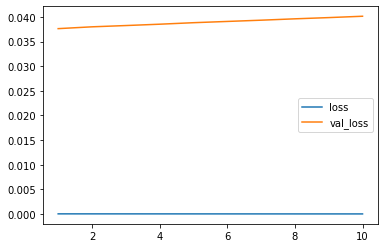

In [93]:
y_loss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = range(1, len(y_loss)+1)
plt.plot(x_len, y_loss, label='loss')
plt.plot(x_len, y_vloss, label='val_loss')
plt.legend()
plt.show()